In [305]:
import importlib
import data_preprocessing
import data_set_and_loader
import models.multihead_pitch_prediction
from layers.lstm import LSTM
importlib.reload(data_preprocessing)
importlib.reload(data_set_and_loader)
importlib.reload(models.multihead_pitch_prediction)

<module 'models.multihead_pitch_prediction' from 'c:\\Users\\Richard\\Documents\\SEG4300\\Project\\SEG4300-Project\\Code\\models\\multihead_pitch_prediction.py'>

In [306]:
import torch
from torch import nn
import torch.optim as optim
import os
import time
from models.multihead_pitch_prediction import MultiHeadLSTM
from data_preprocessing import load_data, sort_n_group, build_seqs, encode_and_scale, compute_feature_medians, split_data
from data_set_and_loader import create_dataloaders, AtBatDataset
from config import DATA_PATH

In [202]:
df = load_data(DATA_PATH)

In [203]:
df = sort_n_group(df)

In [204]:
median_values = compute_feature_medians(df)

In [205]:
X_sequences , Y_sequences = build_seqs(df, median_values)

Finished sequence building. Dropped 52454 at-bats with NaN values.
Dropped 145305 at-bats due to outliers.
Dropped 8496 at-bats due to invalid results: {'strikeout', 'walk', 'strikeout_double_play', 'truncated_pa'}


In [206]:
num_indices = [8, 9, 16, 17, 18, 19, 20]
cat_indices = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 21, 22]

processed_X, processed_Y, label_encoders_X = encode_and_scale(X_sequences, Y_sequences)

In [207]:
X_train, X_test, Y_train, Y_test = split_data(processed_X, processed_Y, test_size=0.2, random_state=42)

In [307]:
train_loader, test_loader = create_dataloaders(X_train, Y_train, X_test, Y_test, 64) #remember to adjust batch-size here too

In [308]:
x_num_indices = [8, 9, 16, 17, 18, 19, 20]
x_low_card_cats_indices = [0, 1, 2, 3, 4, 5, 7, 10, 11, 14]
x_inning_index = 6
x_pitcher_index = 12
x_batter_index = 13
x_prev_pitch_index = 15
x_prev_desc_index = 22
x_prev_event_index = 21

In [312]:
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
MODEL_SAVE_PATH = r"C:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\Code\saved_models\best_model.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model (update parameters based on your dataset)
model = MultiHeadLSTM(
    num_numeric_features=7,
    num_pitchers=879, num_batters=3096,
    num_prev_descriptions=12, num_prev_events=3, num_prev_pitch_types=16,
    num_low_card_cats=10, 
    num_innings=20, inning_emb_dim=3,
    pitcher_emb_dim=9, batter_emb_dim=12,
    prev_description_emb_dim=3, prev_event_emb_dim=2, prev_pitch_emb_dim=3,
    hidden_dim=256,
    num_pitch_type_classes=16, num_description_classes=14, num_event_classes=24,
    cont_dim=5, lstm_layers=2, dropout=0.3
).to(device)

# Loss functions
criterion_classification = nn.CrossEntropyLoss(ignore_index=0)
criterion_continuous = nn.MSELoss(reduction="none")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler: Reduce LR by 50% every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Track best validation loss
best_val_loss = float("inf")


### 🚀 Training Function
def train_one_epoch(epoch):
    model.train()
    total_loss, total_pitch_type_loss, total_desc_loss, total_event_loss, total_cont_loss = 0, 0, 0, 0, 0
    correct_pitch_types, correct_desc, correct_event = 0, 0, 0
    total_pitch_types, total_desc, total_event = 0, 0, 0

    start_time = time.time()

    for batch in train_loader:
        (
            padded_X, padded_Y_type, padded_Y_cont, padded_Y_desc, padded_Y_event, lengths
        ) = [tensor.to(device) for tensor in batch]

        # Extract features based on new indices
        x_num = padded_X[:, :, x_num_indices]  # Numeric features
        x_low_card_cats = padded_X[:, :, x_low_card_cats_indices]  # Low-cardinality categorical
        x_inning = padded_X[:, :, x_inning_index].long()  # Inning (integer categories)
        x_pitcher = padded_X[:, :, x_pitcher_index].long()
        x_batter = padded_X[:, :, x_batter_index].long()
        x_prev_pitch = padded_X[:, :, x_prev_pitch_index].long()
        x_prev_desc = padded_X[:, :, x_prev_desc_index].long()
        x_prev_event = padded_X[:, :, x_prev_event_index].long()

        optimizer.zero_grad()

        # Forward pass
        pitch_type_logits, pitch_cont_values, pitch_result_desc, pitch_result_event = model(
            x_num, x_low_card_cats, x_inning, x_pitcher, x_batter, x_prev_desc, x_prev_event, x_prev_pitch, lengths
        )

        # Compute losses
        loss_pitch_type = criterion_classification(
            pitch_type_logits.view(-1, pitch_type_logits.size(-1)), padded_Y_type.view(-1)
        )
        loss_desc = criterion_classification(
            pitch_result_desc.view(-1, pitch_result_desc.size(-1)), padded_Y_desc.view(-1)
        )
        loss_event = criterion_classification(
            pitch_result_event.view(-1, pitch_result_event.size(-1)), padded_Y_event.view(-1)
        )
        #Handle padded numerical values (-999) in MSE loss
        mask = (padded_Y_cont != -999).float()  # Create a mask (1 for real values, 0 for padded)
        loss_cont = (mask * (pitch_cont_values - padded_Y_cont) ** 2).sum() / mask.sum()

        # Total loss
        loss = loss_pitch_type + loss_desc + loss_event + loss_cont
        loss.backward()
        optimizer.step()

        # Track losses
        total_loss += loss.item()
        total_pitch_type_loss += loss_pitch_type.item()
        total_desc_loss += loss_desc.item()
        total_event_loss += loss_event.item()
        total_cont_loss += loss_cont.item()

        # Compute accuracy for all categorical outputs (ignore padding)
        mask_type = (padded_Y_type != 0)  
        mask_desc = (padded_Y_desc != 0)
        mask_event = (padded_Y_event != 0)

        _, predicted_pitch_type = torch.max(pitch_type_logits, dim=-1)
        _, predicted_desc = torch.max(pitch_result_desc, dim=-1)
        _, predicted_event = torch.max(pitch_result_event, dim=-1)

        correct_pitch_types += (predicted_pitch_type[mask_type] == padded_Y_type[mask_type]).sum().item()
        correct_desc += (predicted_desc[mask_desc] == padded_Y_desc[mask_desc]).sum().item()
        correct_event += (predicted_event[mask_event] == padded_Y_event[mask_event]).sum().item()

        total_pitch_types += mask_type.sum().item()
        total_desc += mask_desc.sum().item()
        total_event += mask_event.sum().item()

    avg_loss = total_loss / len(train_loader)
    pitch_type_acc = 100 * correct_pitch_types / total_pitch_types
    desc_acc = 100 * correct_desc / total_desc
    event_acc = 100 * correct_event / total_event

    end_time = time.time()
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f} - Pitch Type Acc: {pitch_type_acc:.2f}% - Desc Acc: {desc_acc:.2f}% - Event Acc: {event_acc:.2f}% - Time: {end_time - start_time:.2f}s")

    return avg_loss


### 🚀 Validation Function
def validate():
    model.eval()
    val_loss, val_pitch_type_loss, val_desc_loss, val_event_loss, val_cont_loss = 0, 0, 0, 0, 0
    correct_pitch_types, correct_desc, correct_event = 0, 0, 0
    total_pitch_types, total_desc, total_event = 0, 0, 0

    with torch.no_grad():
        for batch in test_loader:
            (
                padded_X, padded_Y_type, padded_Y_cont, padded_Y_desc, padded_Y_event, lengths
            ) = [tensor.to(device) for tensor in batch]

            # Extract features based on new indices
            x_num = padded_X[:, :, x_num_indices]  # Numeric features
            x_low_card_cats = padded_X[:, :, x_low_card_cats_indices]  # Low-cardinality categorical
            x_inning = padded_X[:, :, x_inning_index].long()  # Inning (integer categories)
            x_pitcher = padded_X[:, :, x_pitcher_index].long()
            x_batter = padded_X[:, :, x_batter_index].long()
            x_prev_pitch = padded_X[:, :, x_prev_pitch_index].long()
            x_prev_desc = padded_X[:, :, x_prev_desc_index].long()
            x_prev_event = padded_X[:, :, x_prev_event_index].long()

            pitch_type_logits, pitch_cont_values, pitch_result_desc, pitch_result_event = model(
                x_num, x_low_card_cats, x_inning, x_pitcher, x_batter, x_prev_desc, x_prev_event, x_prev_pitch, lengths
            )

            # Compute validation losses
            loss_pitch_type = criterion_classification(
                pitch_type_logits.view(-1, pitch_type_logits.size(-1)), padded_Y_type.view(-1)
            )
            loss_desc = criterion_classification(
                pitch_result_desc.view(-1, pitch_result_desc.size(-1)), padded_Y_desc.view(-1)
            )
            loss_event = criterion_classification(
                pitch_result_event.view(-1, pitch_result_event.size(-1)), padded_Y_event.view(-1)
            )
            mask = (padded_Y_cont != -999).float()
            loss_cont = (mask * (pitch_cont_values - padded_Y_cont) ** 2).sum() / mask.sum()

            loss = loss_pitch_type + loss_desc + loss_event + loss_cont
            val_loss += loss.item()

            # Compute accuracy for all categorical outputs (ignore padding)
            mask_type = (padded_Y_type != 0)  
            mask_desc = (padded_Y_desc != 0)
            mask_event = (padded_Y_event != 0)

            _, predicted_pitch_type = torch.max(pitch_type_logits, dim=-1)
            _, predicted_desc = torch.max(pitch_result_desc, dim=-1)
            _, predicted_event = torch.max(pitch_result_event, dim=-1)

            correct_pitch_types += (predicted_pitch_type[mask_type] == padded_Y_type[mask_type]).sum().item()
            correct_desc += (predicted_desc[mask_desc] == padded_Y_desc[mask_desc]).sum().item()
            correct_event += (predicted_event[mask_event] == padded_Y_event[mask_event]).sum().item()

            total_pitch_types += mask_type.sum().item()
            total_desc += mask_desc.sum().item()
            total_event += mask_event.sum().item()

    avg_val_loss = val_loss / len(test_loader)
    pitch_type_acc = 100 * correct_pitch_types / total_pitch_types
    desc_acc = 100 * correct_desc / total_desc
    event_acc = 100 * correct_event / total_event

    print(f"Validation Loss: {avg_val_loss:.4f} - Pitch Type Acc: {pitch_type_acc:.2f}% - Desc Acc: {desc_acc:.2f}% - Event Acc: {event_acc:.2f}%")

    return avg_val_loss


early_stopping_patience = 5
no_improvement_epochs = 0

### 🚀 Training Loop
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(epoch)
    val_loss = validate()

    if val_loss < best_val_loss:
        print("🔥 New best model found! Saving...")
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    scheduler.step()

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered")
        break

print("Training complete! Best model saved as", MODEL_SAVE_PATH)

Using device: cpu
Epoch [1/20] - Loss: 5.0019 - Pitch Type Acc: 45.00% - Desc Acc: 37.29% - Event Acc: 50.32% - Time: 574.20s
Validation Loss: 4.7798 - Pitch Type Acc: 47.26% - Desc Acc: 37.77% - Event Acc: 51.20%
🔥 New best model found! Saving...
Epoch [2/20] - Loss: 4.7727 - Pitch Type Acc: 47.25% - Desc Acc: 37.84% - Event Acc: 51.25% - Time: 556.63s
Validation Loss: 4.7386 - Pitch Type Acc: 47.79% - Desc Acc: 37.97% - Event Acc: 51.37%
🔥 New best model found! Saving...
Epoch [3/20] - Loss: 4.7464 - Pitch Type Acc: 47.59% - Desc Acc: 37.98% - Event Acc: 51.38% - Time: 558.36s
Validation Loss: 4.7221 - Pitch Type Acc: 48.02% - Desc Acc: 38.05% - Event Acc: 51.43%
🔥 New best model found! Saving...
Epoch [4/20] - Loss: 4.7347 - Pitch Type Acc: 47.78% - Desc Acc: 38.02% - Event Acc: 51.40% - Time: 558.51s
Validation Loss: 4.7163 - Pitch Type Acc: 48.13% - Desc Acc: 38.09% - Event Acc: 51.49%
🔥 New best model found! Saving...
Epoch [5/20] - Loss: 4.7283 - Pitch Type Acc: 47.90% - Desc Ac

KeyboardInterrupt: 

In [282]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(model, sample_batch, lengths):
    """
    Visualizes the LSTM's attention over past pitches using hidden states.
    """
    model.eval()
    with torch.no_grad():
        (
            padded_X, padded_Y_type, padded_Y_cont, padded_Y_desc, padded_Y_event, lengths
        ) = [tensor.to(device) for tensor in sample_batch]

        # Extract features based on new indices
        x_num = padded_X[:, :, x_num_indices]  
        x_low_card_cats = padded_X[:, :, x_low_card_cats_indices]
        x_inning = padded_X[:, :, x_inning_index].long()  
        x_pitcher = padded_X[:, :, x_pitcher_index].long()
        x_batter = padded_X[:, :, x_batter_index].long()
        x_prev_pitch = padded_X[:, :, x_prev_pitch_index].long()
        x_prev_desc = padded_X[:, :, x_prev_desc_index].long()
        x_prev_event = padded_X[:, :, x_prev_event_index].long()

        # Forward pass to extract LSTM hidden states
        _, (h_n, c_n) = model.lstm(
            torch.cat([x_num, x_low_card_cats], dim=2)
        )

        attention_scores = torch.mean(h_n, dim=0).cpu().numpy()

    # Plot attention over sequence length
    plt.figure(figsize=(10, 5))
    sns.heatmap(attention_scores.T, cmap="viridis", annot=False)
    plt.xlabel("LSTM Layer")
    plt.ylabel("Sequence Length")
    plt.title("LSTM Hidden State Attention Heatmap")
    plt.show()


In [290]:
from sklearn.manifold import TSNE

def plot_embeddings(embedding_matrix, labels, title):
    """
    Visualizes high-dimensional learned embeddings using t-SNE.
    """
    num_samples = embedding_matrix.shape[0]  # Number of embeddings
    perplexity = min(5, num_samples - 1)  # Ensure perplexity < num_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embedded_2d = tsne.fit_transform(embedding_matrix.cpu().detach().numpy())

    plt.figure(figsize=(10, 7))
    plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")
    
    for i, label in enumerate(labels):
        plt.text(embedded_2d[i, 0], embedded_2d[i, 1], str(label), fontsize=9, alpha=0.8)
    
    plt.title(title)
    plt.show()

# Extract learned embeddings
def inspect_learned_embeddings():
    """
    Extracts and visualizes learned embeddings for pitchers, batters, and innings.
    """
    model.eval()
    pitcher_embeddings = model.pitcher_emb.weight
    batter_embeddings = model.batter_emb.weight
    inning_embeddings = model.inning_emb.weight
    prev_desc_embs = model.prev_description_emb.weight
    prev_event_embs = model.prev_event_emb.weight
    prev_pitch_embs = model.prev_pitch_emb.weight

    plot_embeddings(pitcher_embeddings, range(len(pitcher_embeddings)), "Pitcher Embeddings")
    plot_embeddings(batter_embeddings, range(len(batter_embeddings)), "Batter Embeddings")
    plot_embeddings(inning_embeddings, range(len(inning_embeddings)), "Inning Embeddings")
    plot_embeddings(prev_desc_embs, range(len(prev_desc_embs)), "Prev Desc Embeddings")
    plot_embeddings(prev_event_embs, range(len(prev_event_embs)), "Prev Event Embeddings")
    plot_embeddings(prev_pitch_embs, range(len(prev_pitch_embs)), "Prev Pitch Embeddings")



C:\Users\Richard\AppData\Local\Temp\ipykernel_20088\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


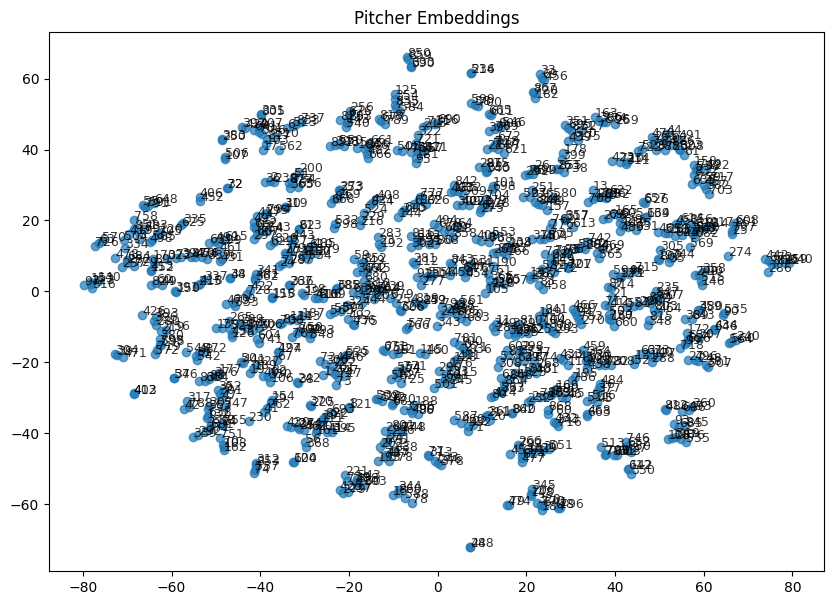

C:\Users\Richard\AppData\Local\Temp\ipykernel_20088\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


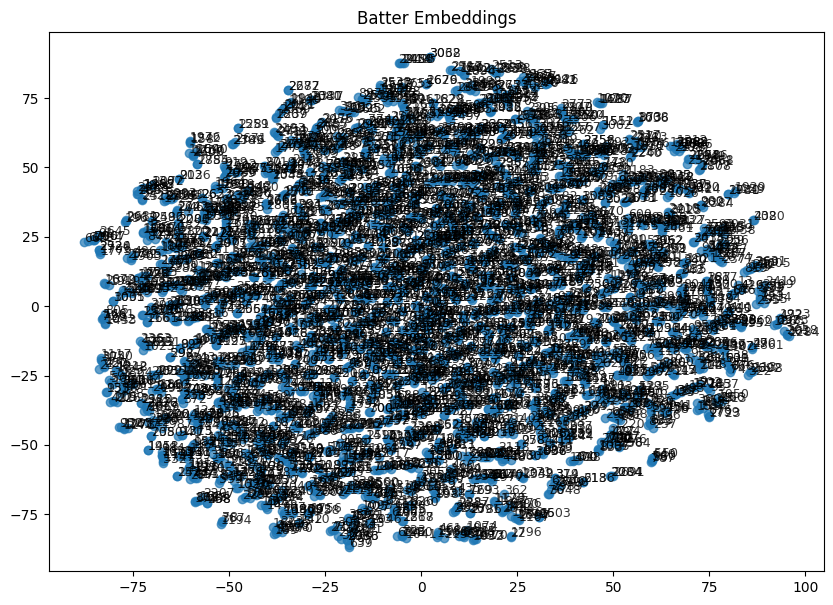

C:\Users\Richard\AppData\Local\Temp\ipykernel_20088\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


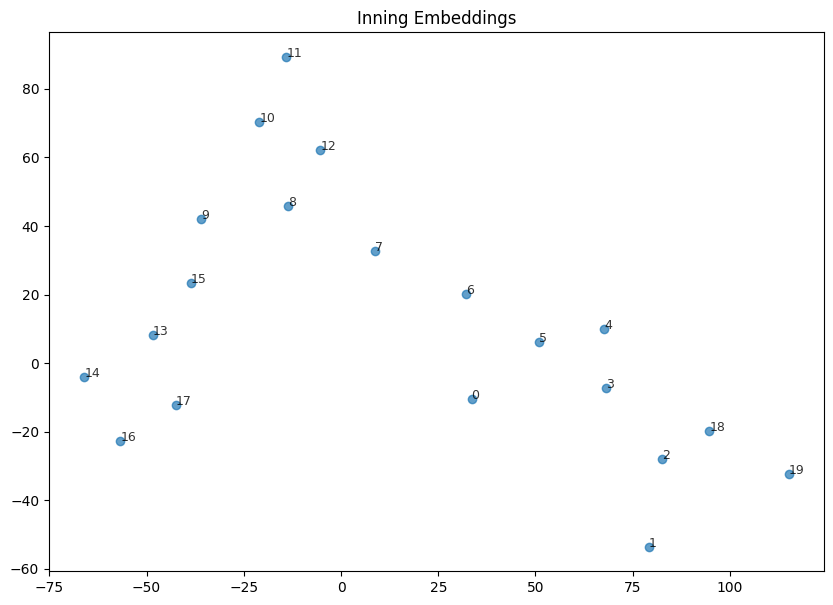

C:\Users\Richard\AppData\Local\Temp\ipykernel_20088\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


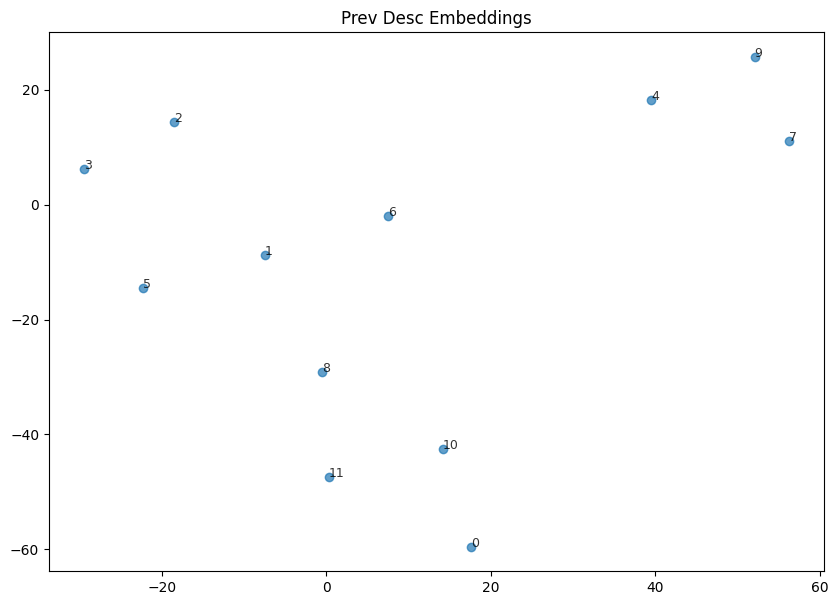

C:\Users\Richard\AppData\Local\Temp\ipykernel_20088\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


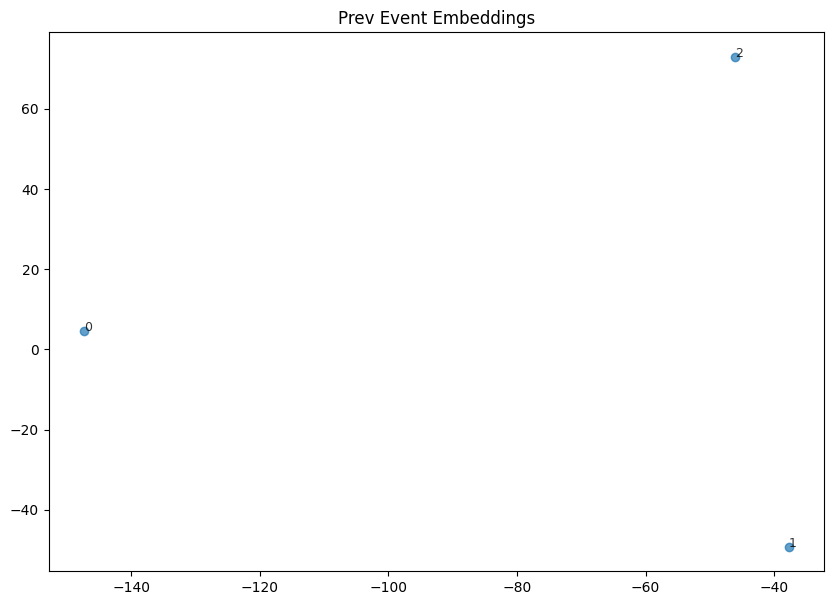

C:\Users\Richard\AppData\Local\Temp\ipykernel_20088\4011387956.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.7, cmap="viridis")


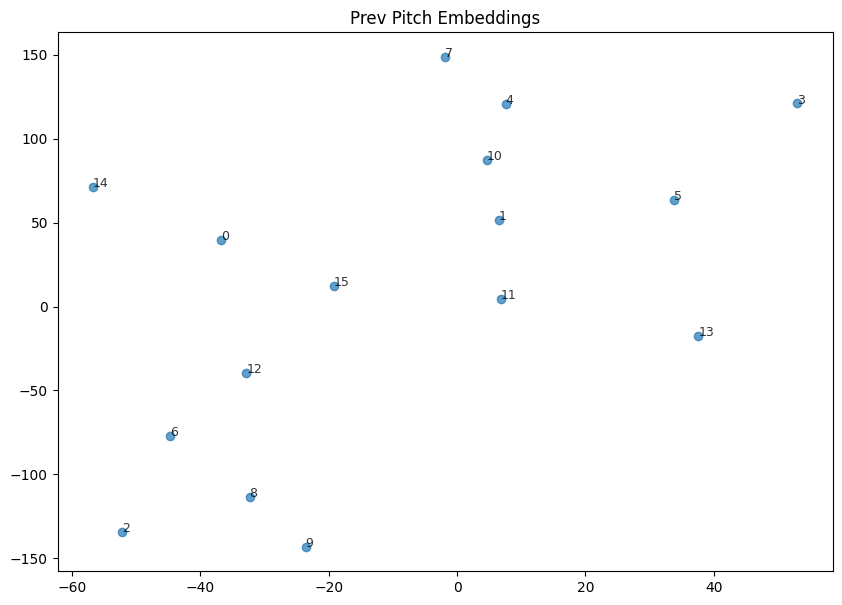

In [291]:
# Visualize LSTM attention for a random batch
#sample_batch = next(iter(test_loader))
#visualize_attention(model, sample_batch, lengths)

# Inspect learned pitcher/batter/inning embeddings
inspect_learned_embeddings()

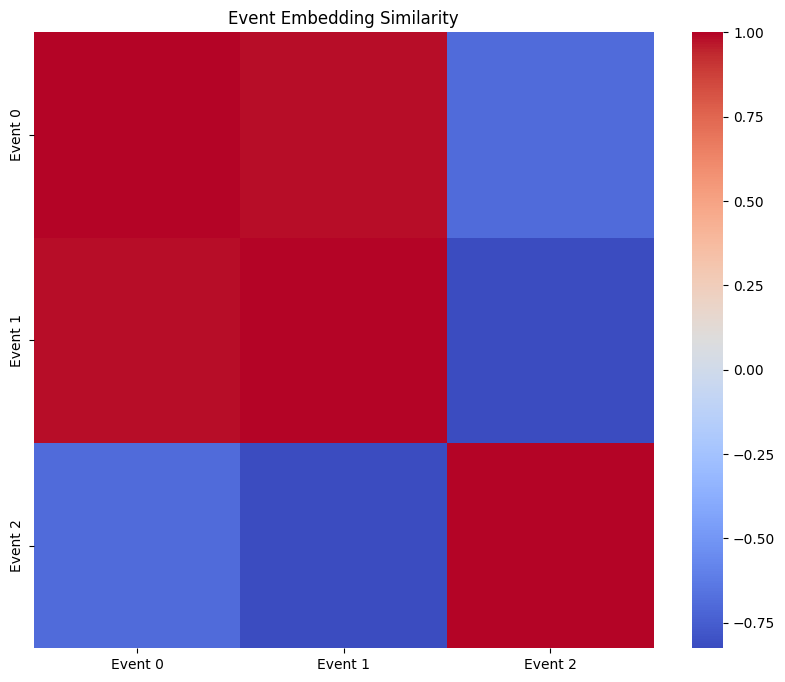

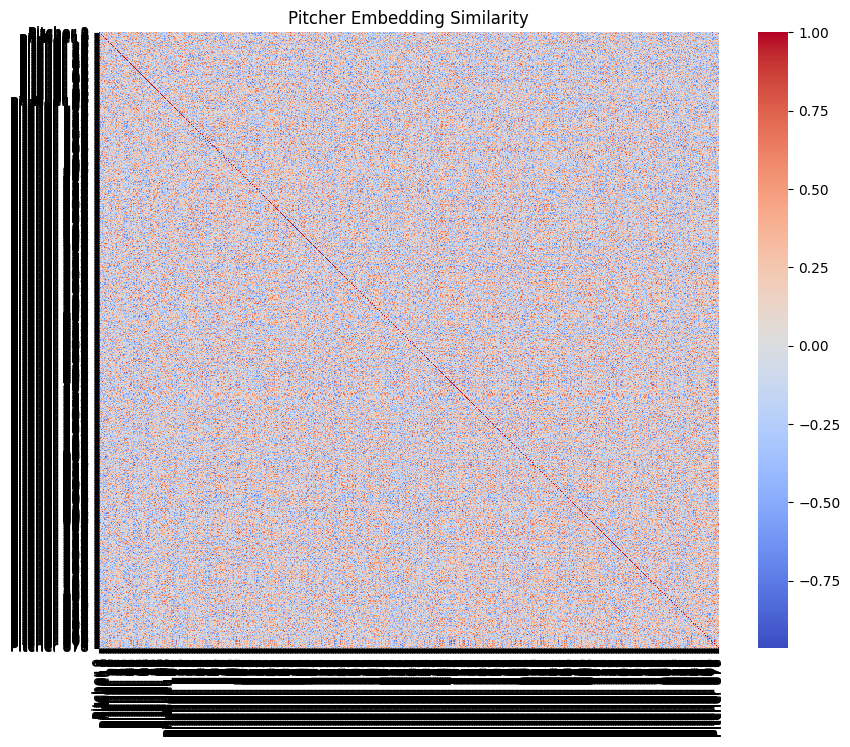

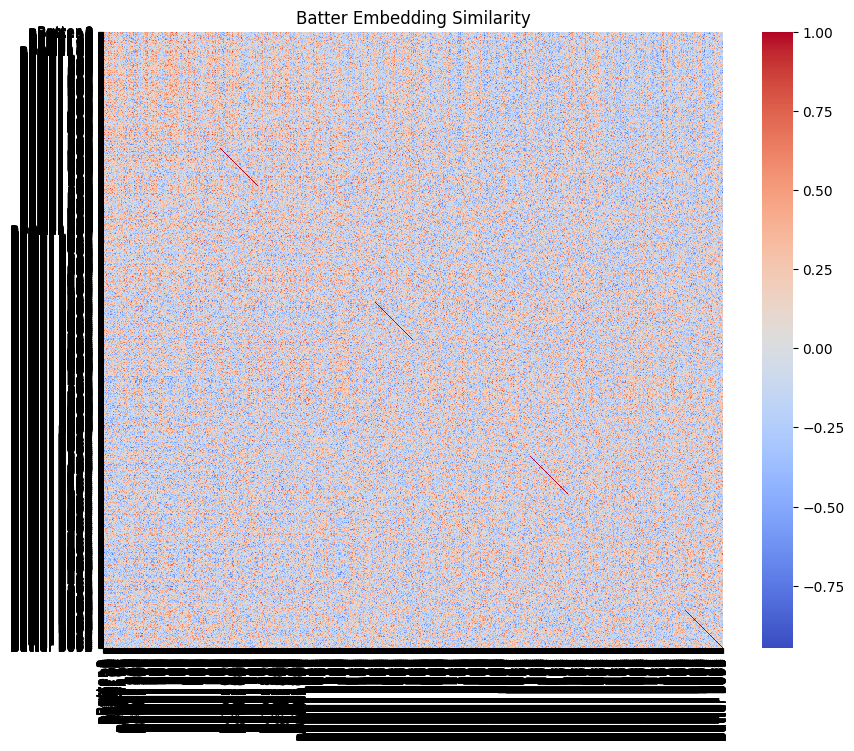

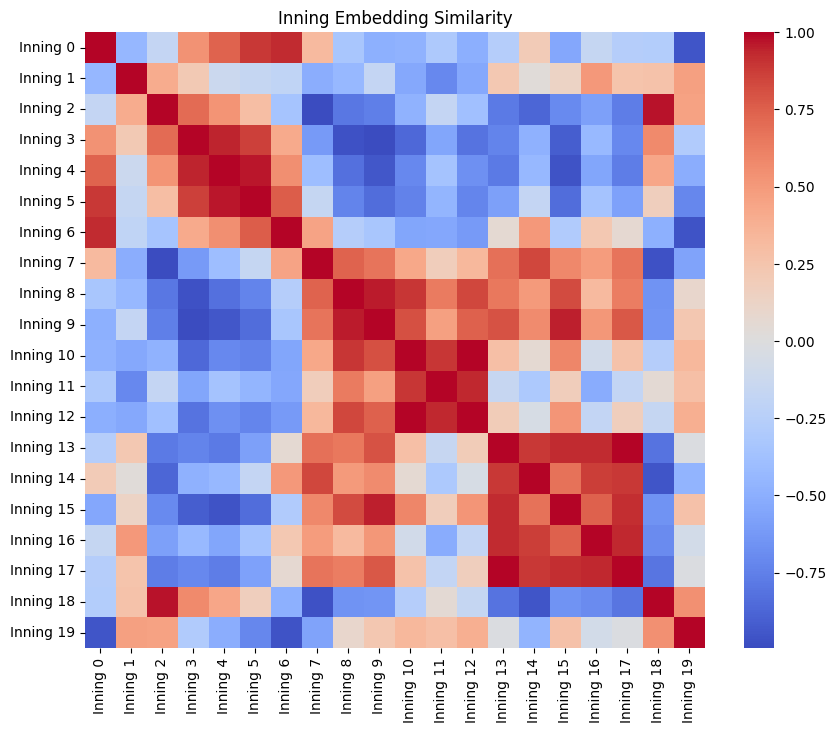

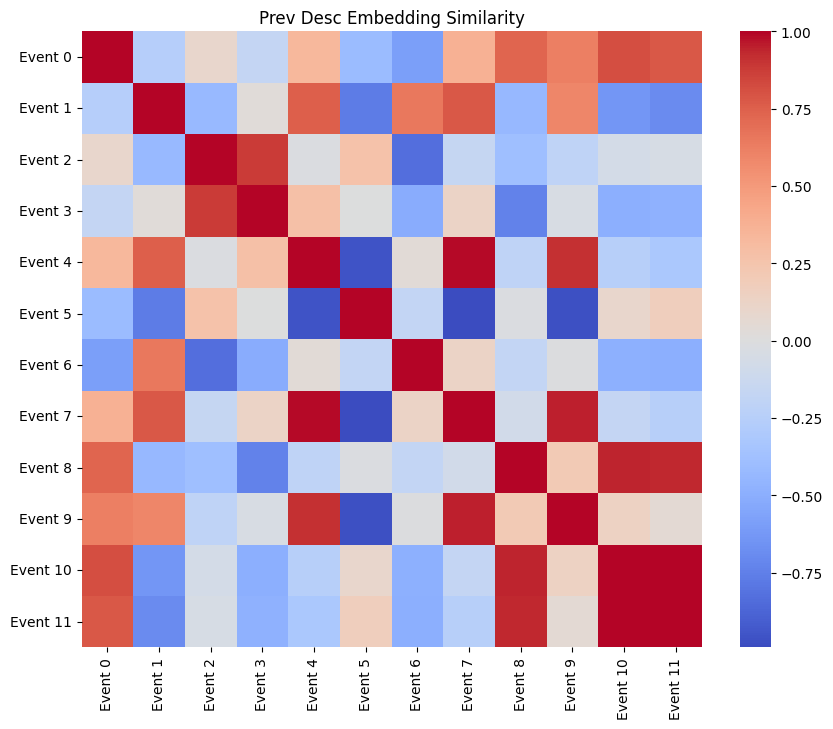

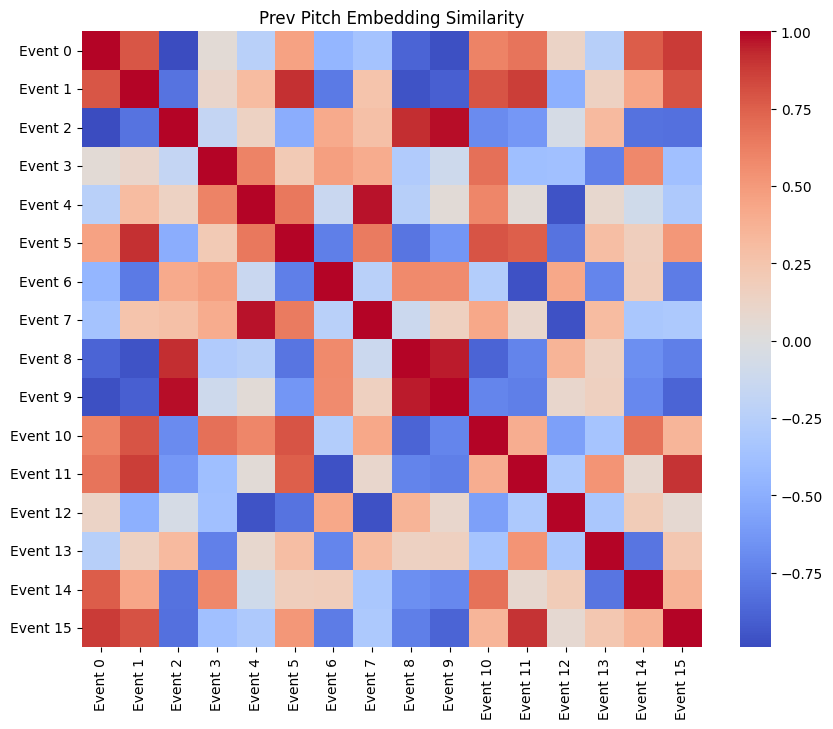

In [295]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def compute_embedding_similarity(embedding_matrix, labels, title="Embedding Similarity"):
    """
    Compute cosine similarity between embeddings and visualize it.
    
    embedding_matrix: torch.Tensor (num_classes, embedding_dim)
    labels: list of class labels
    title: Title for the heatmap
    """
    # Convert embeddings to numpy
    embeddings = embedding_matrix.cpu().detach().numpy()

    # Compute cosine similarity
    similarity_matrix = np.dot(embeddings, embeddings.T)
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    similarity_matrix /= (norms @ norms.T)  # Normalize

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=False, cmap="coolwarm", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.show()

# Extract learned embeddings from the trained model
event_embeddings = model.prev_event_emb.weight  # Shape: (num_events, emb_dim)
pitcher_embeddings = model.pitcher_emb.weight
batter_embeddings = model.batter_emb.weight
inning_embeddings = model.inning_emb.weight
prev_desc_embs = model.prev_description_emb.weight
prev_pitch_embs = model.prev_pitch_emb.weight

# Define labels (Replace with actual event names if available)
event_labels = [f"Event {i}" for i in range(event_embeddings.shape[0])]
pitcher_labels = [f"Pitcher {i}" for i in range(pitcher_embeddings.shape[0])]
batter_labels = [f"Batter {i}" for i in range(batter_embeddings.shape[0])]
inning_labels = [f"Inning {i}" for i in range(inning_embeddings.shape[0])]
prev_desc_labels = [f"Event {i}" for i in range(prev_desc_embs.shape[0])]
prev_pitch_labels = [f"Event {i}" for i in range(prev_pitch_embs.shape[0])]

# Compute and visualize event embedding similarity
compute_embedding_similarity(event_embeddings, event_labels, title="Event Embedding Similarity")
compute_embedding_similarity(pitcher_embeddings, pitcher_labels, title="Pitcher Embedding Similarity")
compute_embedding_similarity(batter_embeddings, batter_labels, title="Batter Embedding Similarity")
compute_embedding_similarity(inning_embeddings, inning_labels, title="Inning Embedding Similarity")
compute_embedding_similarity(prev_desc_embs, prev_desc_labels, title="Prev Desc Embedding Similarity")
compute_embedding_similarity(prev_pitch_embs, prev_pitch_labels, title="Prev Pitch Embedding Similarity")


In [ ]:
EPOCHS = 25
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
MODEL_SAVE_PATH = r"C:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\Code\saved_models\best_model.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model (update parameters based on your dataset)
model = MultiHeadLSTM(
    num_numeric_features=7,
    num_pitchers=879, num_batters=3096,
    num_prev_descriptions=12, num_prev_events=3, num_prev_pitch_types=16,
    num_low_card_cats=10, 
    num_innings=20, inning_emb_dim=3,
    pitcher_emb_dim=9, batter_emb_dim=12,
    prev_description_emb_dim=3, prev_event_emb_dim=2, prev_pitch_emb_dim=3,
    hidden_dim=128,
    num_pitch_type_classes=16, num_description_classes=14, num_event_classes=24,
    cont_dim=5, lstm_layers=2, dropout=0.2
).to(device)

# Loss functions
criterion_classification = nn.CrossEntropyLoss(ignore_index=0)
criterion_continuous = nn.MSELoss(reduction="none")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Track best validation loss
best_val_loss = float("inf")


### 🚀 Training Function
def train_one_epoch(epoch):
    model.train()
    total_loss, total_pitch_type_loss, total_desc_loss, total_event_loss, total_cont_loss = 0, 0, 0, 0, 0
    correct_pitch_types, correct_desc, correct_event = 0, 0, 0
    total_pitch_types, total_desc, total_event = 0, 0, 0

    start_time = time.time()

    for batch in train_loader:
        (
            padded_X, padded_Y_type, padded_Y_cont, padded_Y_desc, padded_Y_event, lengths
        ) = [tensor.to(device) for tensor in batch]

        # Extract features based on new indices
        x_num = padded_X[:, :, x_num_indices]  # Numeric features
        x_low_card_cats = padded_X[:, :, x_low_card_cats_indices]  # Low-cardinality categorical
        x_inning = padded_X[:, :, x_inning_index].long()  # Inning (integer categories)
        x_pitcher = padded_X[:, :, x_pitcher_index].long()
        x_batter = padded_X[:, :, x_batter_index].long()
        x_prev_pitch = padded_X[:, :, x_prev_pitch_index].long()
        x_prev_desc = padded_X[:, :, x_prev_desc_index].long()
        x_prev_event = padded_X[:, :, x_prev_event_index].long()

        optimizer.zero_grad()

        # Forward pass
        pitch_type_logits, pitch_cont_values, pitch_result_desc, pitch_result_event = model(
            x_num, x_low_card_cats, x_inning, x_pitcher, x_batter, x_prev_desc, x_prev_event, x_prev_pitch, lengths
        )

        # Compute losses
        loss_pitch_type = criterion_classification(
            pitch_type_logits.view(-1, pitch_type_logits.size(-1)), padded_Y_type.view(-1)
        )
        loss_desc = criterion_classification(
            pitch_result_desc.view(-1, pitch_result_desc.size(-1)), padded_Y_desc.view(-1)
        )
        loss_event = criterion_classification(
            pitch_result_event.view(-1, pitch_result_event.size(-1)), padded_Y_event.view(-1)
        )
        #Handle padded numerical values (-999) in MSE loss
        mask = (padded_Y_cont != -999).float()  # Create a mask (1 for real values, 0 for padded)
        loss_cont = (mask * (pitch_cont_values - padded_Y_cont) ** 2).sum() / mask.sum()

        # Total loss
        loss = loss_pitch_type + loss_desc + loss_event + loss_cont
        loss.backward()
        optimizer.step()

        # Track losses
        total_loss += loss.item()
        total_pitch_type_loss += loss_pitch_type.item()
        total_desc_loss += loss_desc.item()
        total_event_loss += loss_event.item()
        total_cont_loss += loss_cont.item()

        # Compute accuracy for all categorical outputs (ignore padding)
        mask_type = (padded_Y_type != 0)  
        mask_desc = (padded_Y_desc != 0)
        mask_event = (padded_Y_event != 0)

        _, predicted_pitch_type = torch.max(pitch_type_logits, dim=-1)
        _, predicted_desc = torch.max(pitch_result_desc, dim=-1)
        _, predicted_event = torch.max(pitch_result_event, dim=-1)

        correct_pitch_types += (predicted_pitch_type[mask_type] == padded_Y_type[mask_type]).sum().item()
        correct_desc += (predicted_desc[mask_desc] == padded_Y_desc[mask_desc]).sum().item()
        correct_event += (predicted_event[mask_event] == padded_Y_event[mask_event]).sum().item()

        total_pitch_types += mask_type.sum().item()
        total_desc += mask_desc.sum().item()
        total_event += mask_event.sum().item()

    avg_loss = total_loss / len(train_loader)
    pitch_type_acc = 100 * correct_pitch_types / total_pitch_types
    desc_acc = 100 * correct_desc / total_desc
    event_acc = 100 * correct_event / total_event

    end_time = time.time()
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f} - Pitch Type Acc: {pitch_type_acc:.2f}% - Desc Acc: {desc_acc:.2f}% - Event Acc: {event_acc:.2f}% - Time: {end_time - start_time:.2f}s")

    return avg_loss


### 🚀 Validation Function
def validate():
    model.eval()
    val_loss, val_pitch_type_loss, val_desc_loss, val_event_loss, val_cont_loss = 0, 0, 0, 0, 0
    correct_pitch_types, correct_desc, correct_event = 0, 0, 0
    total_pitch_types, total_desc, total_event = 0, 0, 0

    with torch.no_grad():
        for batch in test_loader:
            (
                padded_X, padded_Y_type, padded_Y_cont, padded_Y_desc, padded_Y_event, lengths
            ) = [tensor.to(device) for tensor in batch]

            # Extract features based on new indices
            x_num = padded_X[:, :, x_num_indices]  # Numeric features
            x_low_card_cats = padded_X[:, :, x_low_card_cats_indices]  # Low-cardinality categorical
            x_inning = padded_X[:, :, x_inning_index].long()  # Inning (integer categories)
            x_pitcher = padded_X[:, :, x_pitcher_index].long()
            x_batter = padded_X[:, :, x_batter_index].long()
            x_prev_pitch = padded_X[:, :, x_prev_pitch_index].long()
            x_prev_desc = padded_X[:, :, x_prev_desc_index].long()
            x_prev_event = padded_X[:, :, x_prev_event_index].long()

            pitch_type_logits, pitch_cont_values, pitch_result_desc, pitch_result_event = model(
                x_num, x_low_card_cats, x_inning, x_pitcher, x_batter, x_prev_desc, x_prev_event, x_prev_pitch, lengths
            )

            # Compute validation losses
            loss_pitch_type = criterion_classification(
                pitch_type_logits.view(-1, pitch_type_logits.size(-1)), padded_Y_type.view(-1)
            )
            loss_desc = criterion_classification(
                pitch_result_desc.view(-1, pitch_result_desc.size(-1)), padded_Y_desc.view(-1)
            )
            loss_event = criterion_classification(
                pitch_result_event.view(-1, pitch_result_event.size(-1)), padded_Y_event.view(-1)
            )
            mask = (padded_Y_cont != -999).float()
            loss_cont = (mask * (pitch_cont_values - padded_Y_cont) ** 2).sum() / mask.sum()

            loss = loss_pitch_type + loss_desc + loss_event + loss_cont
            val_loss += loss.item()

            # Compute accuracy for all categorical outputs (ignore padding)
            mask_type = (padded_Y_type != 0)  
            mask_desc = (padded_Y_desc != 0)
            mask_event = (padded_Y_event != 0)

            _, predicted_pitch_type = torch.max(pitch_type_logits, dim=-1)
            _, predicted_desc = torch.max(pitch_result_desc, dim=-1)
            _, predicted_event = torch.max(pitch_result_event, dim=-1)

            correct_pitch_types += (predicted_pitch_type[mask_type] == padded_Y_type[mask_type]).sum().item()
            correct_desc += (predicted_desc[mask_desc] == padded_Y_desc[mask_desc]).sum().item()
            correct_event += (predicted_event[mask_event] == padded_Y_event[mask_event]).sum().item()

            total_pitch_types += mask_type.sum().item()
            total_desc += mask_desc.sum().item()
            total_event += mask_event.sum().item()

    avg_val_loss = val_loss / len(test_loader)
    pitch_type_acc = 100 * correct_pitch_types / total_pitch_types
    desc_acc = 100 * correct_desc / total_desc
    event_acc = 100 * correct_event / total_event

    print(f"Validation Loss: {avg_val_loss:.4f} - Pitch Type Acc: {pitch_type_acc:.2f}% - Desc Acc: {desc_acc:.2f}% - Event Acc: {event_acc:.2f}%")

    return avg_val_loss


early_stopping_patience = 5
no_improvement_epochs = 0

### 🚀 Training Loop
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(epoch)
    val_loss = validate()

    if val_loss < best_val_loss:
        print("🔥 New best model found! Saving...")
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        best_val_loss = val_loss
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered")
        break

print("Training complete! Best model saved as", MODEL_SAVE_PATH)

Using device: cpu
Epoch [1/25] - Loss: 5.3140 - Pitch Type Acc: 41.85% - Desc Acc: 37.11% - Event Acc: 49.61% - Time: 458.69s
Validation Loss: 4.9667 - Pitch Type Acc: 45.89% - Desc Acc: 37.48% - Event Acc: 50.55%
🔥 New best model found! Saving...
Epoch [2/25] - Loss: 4.8973 - Pitch Type Acc: 46.38% - Desc Acc: 37.58% - Event Acc: 50.74% - Time: 450.39s
Validation Loss: 4.8072 - Pitch Type Acc: 47.45% - Desc Acc: 37.70% - Event Acc: 51.04%
🔥 New best model found! Saving...
Epoch [3/25] - Loss: 4.7997 - Pitch Type Acc: 47.29% - Desc Acc: 37.80% - Event Acc: 51.16% - Time: 444.68s
Validation Loss: 4.7519 - Pitch Type Acc: 47.99% - Desc Acc: 37.76% - Event Acc: 51.35%
🔥 New best model found! Saving...
Epoch [4/25] - Loss: 4.7571 - Pitch Type Acc: 47.81% - Desc Acc: 37.96% - Event Acc: 51.43% - Time: 444.27s
Validation Loss: 4.7243 - Pitch Type Acc: 48.34% - Desc Acc: 37.91% - Event Acc: 51.42%
🔥 New best model found! Saving...
Epoch [5/25] - Loss: 4.7312 - Pitch Type Acc: 48.09% - Desc Ac


🚀 Analyzing Train DataLoader...

🟢 Batch 1:
  - padded_X shape: torch.Size([32, 6, 23]) (Batch: 32, Max Seq Length: 6, Features: 23)
  - padded_Y_type shape: torch.Size([32, 6])
  - padded_Y_cont shape: torch.Size([32, 6, 5])
  - padded_Y_desc shape: torch.Size([32, 6])
  - padded_Y_event shape: torch.Size([32, 6])
  - Lengths tensor shape: torch.Size([32])

🟢 Batch 2:
  - padded_X shape: torch.Size([32, 8, 23]) (Batch: 32, Max Seq Length: 8, Features: 23)
  - padded_Y_type shape: torch.Size([32, 8])
  - padded_Y_cont shape: torch.Size([32, 8, 5])
  - padded_Y_desc shape: torch.Size([32, 8])
  - padded_Y_event shape: torch.Size([32, 8])
  - Lengths tensor shape: torch.Size([32])

🟢 Batch 3:
  - padded_X shape: torch.Size([32, 7, 23]) (Batch: 32, Max Seq Length: 7, Features: 23)
  - padded_Y_type shape: torch.Size([32, 7])
  - padded_Y_cont shape: torch.Size([32, 7, 5])
  - padded_Y_desc shape: torch.Size([32, 7])
  - padded_Y_event shape: torch.Size([32, 7])
  - Lengths tensor shape: 

c:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


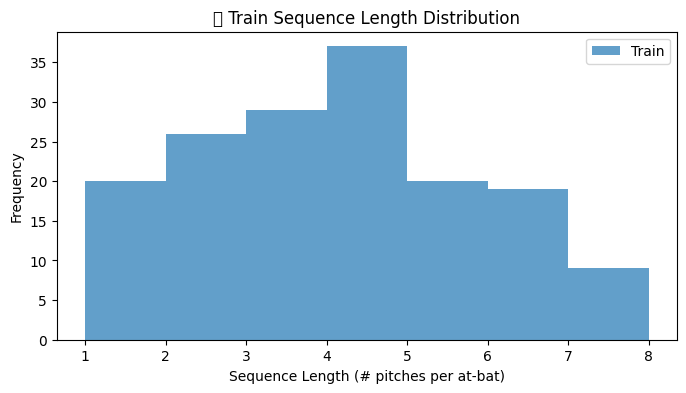

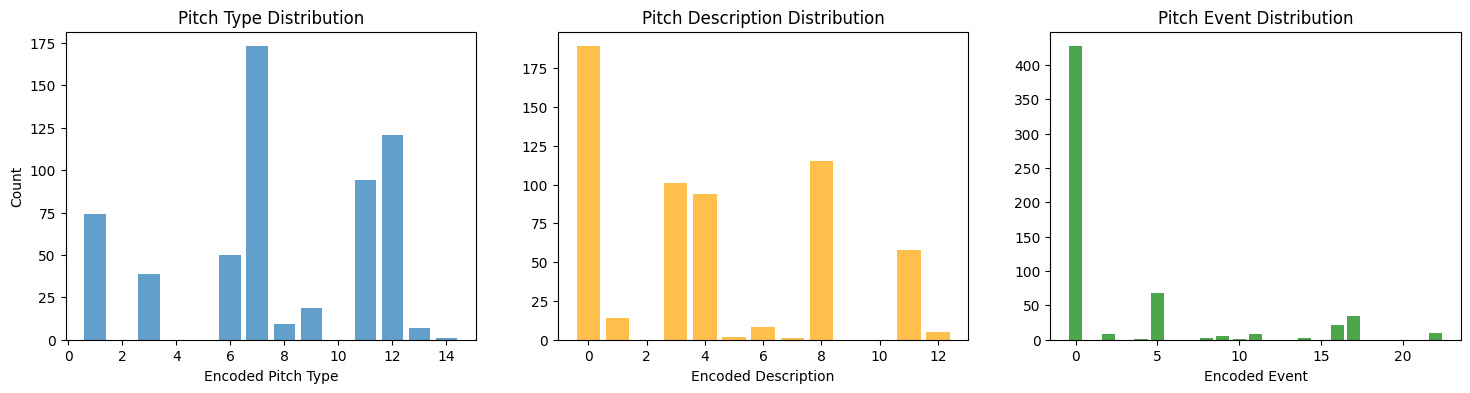


=== Numerical Feature Scaling Check (Y_cont) ===
Mean values (should be ~0 after scaling): -0.022319547832012177
Standard deviations (should be ~1 after scaling): 0.9871117472648621
✅ Scaling verified.

✅ DataLoader Analysis Completed!


🚀 Analyzing Test DataLoader...

🟢 Batch 1:
  - padded_X shape: torch.Size([32, 9, 23]) (Batch: 32, Max Seq Length: 9, Features: 23)
  - padded_Y_type shape: torch.Size([32, 9])
  - padded_Y_cont shape: torch.Size([32, 9, 5])
  - padded_Y_desc shape: torch.Size([32, 9])
  - padded_Y_event shape: torch.Size([32, 9])
  - Lengths tensor shape: torch.Size([32])

🟢 Batch 2:
  - padded_X shape: torch.Size([32, 6, 23]) (Batch: 32, Max Seq Length: 6, Features: 23)
  - padded_Y_type shape: torch.Size([32, 6])
  - padded_Y_cont shape: torch.Size([32, 6, 5])
  - padded_Y_desc shape: torch.Size([32, 6])
  - padded_Y_event shape: torch.Size([32, 6])
  - Lengths tensor shape: torch.Size([32])

🟢 Batch 3:
  - padded_X shape: torch.Size([32, 7, 23]) (Batch: 32, Max Se

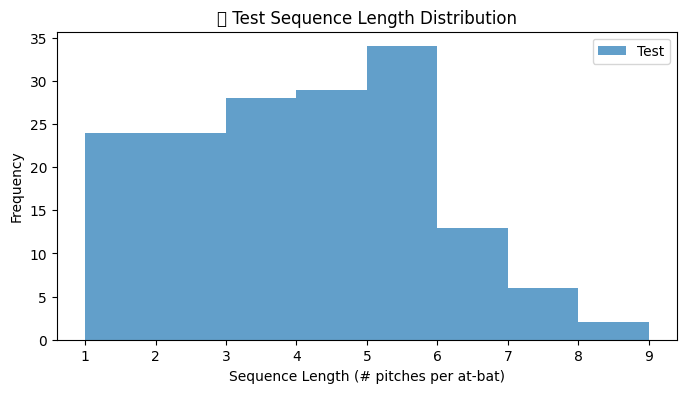

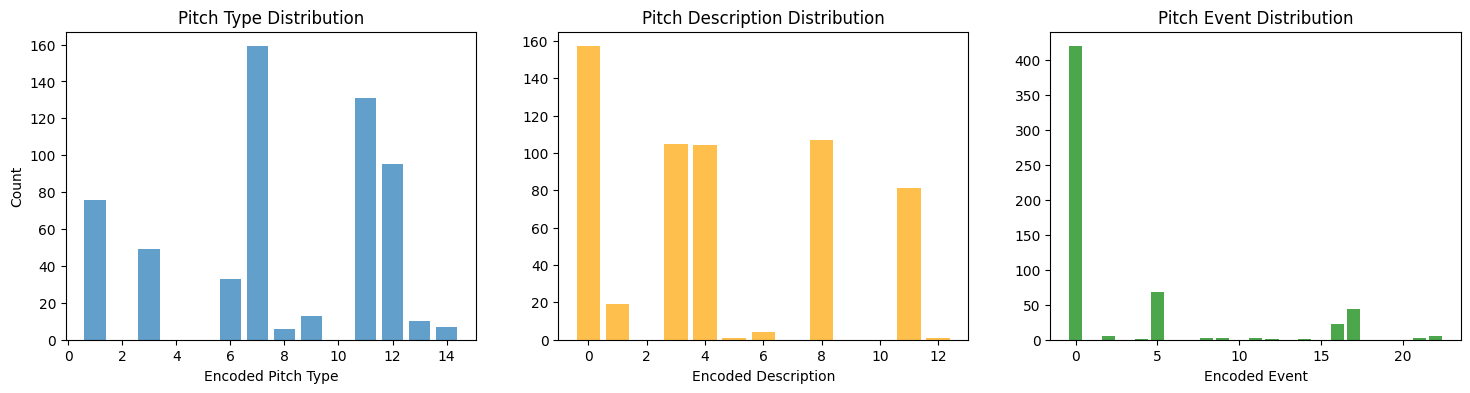


=== Numerical Feature Scaling Check (Y_cont) ===
Mean values (should be ~0 after scaling): -0.03446563705801964
Standard deviations (should be ~1 after scaling): 1.0226967334747314
✅ Scaling verified.

✅ DataLoader Analysis Completed!



In [192]:
import matplotlib.pyplot as plt
import torch
from collections import Counter

def analyze_dataloader(dataloader, dataset_name="Train"):
    """
    Analyzes a given DataLoader by inspecting batch shapes, categorical distributions, and numerical statistics.
    """
    print(f"\n🚀 Analyzing {dataset_name} DataLoader...\n")
    
    # Storage for analysis
    sequence_lengths = []
    type_counts = Counter()
    desc_counts = Counter()
    event_counts = Counter()
    cont_values = []
    
    batch_count = 0

    # Iterate over a few batches to gather statistics
    for batch in dataloader:
        padded_X, padded_Y_type, padded_Y_cont, padded_Y_desc, padded_Y_event, lengths = batch
        batch_size, max_seq_len, input_dim = padded_X.shape
        
        print(f"🟢 Batch {batch_count+1}:")
        print(f"  - padded_X shape: {padded_X.shape} (Batch: {batch_size}, Max Seq Length: {max_seq_len}, Features: {input_dim})")
        print(f"  - padded_Y_type shape: {padded_Y_type.shape}")
        print(f"  - padded_Y_cont shape: {padded_Y_cont.shape}")
        print(f"  - padded_Y_desc shape: {padded_Y_desc.shape}")
        print(f"  - padded_Y_event shape: {padded_Y_event.shape}")
        print(f"  - Lengths tensor shape: {lengths.shape}\n")
        
        # Collect sequence lengths
        sequence_lengths.extend(lengths.tolist())

        # Collect categorical distributions
        type_counts.update(padded_Y_type[padded_Y_type != -100].tolist())  # Ignore padding
        desc_counts.update(padded_Y_desc[padded_Y_desc != -100].tolist())  
        event_counts.update(padded_Y_event[padded_Y_event != -100].tolist())  

        # Collect numerical Y_cont values
        valid_Y_cont = padded_Y_cont[padded_Y_cont != -999]  # Ignore padding
        if valid_Y_cont.numel() > 0:
            cont_values.extend(valid_Y_cont.tolist()) 
        
        batch_count += 1
        if batch_count >= 5:  # Analyze first 5 batches only
            break  

    # ✅ 1️⃣ Sequence Length Distribution
    plt.figure(figsize=(8, 4))
    plt.hist(sequence_lengths, bins=range(1, max(sequence_lengths) + 1), alpha=0.7, label=dataset_name)
    plt.xlabel("Sequence Length (# pitches per at-bat)")
    plt.ylabel("Frequency")
    plt.title(f"📊 {dataset_name} Sequence Length Distribution")
    plt.legend()
    plt.show()

    # ✅ 2️⃣ Target Categorical Distribution (Pitch Type, Description, Event)
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    axes[0].bar(type_counts.keys(), type_counts.values(), alpha=0.7)
    axes[0].set_title("Pitch Type Distribution")
    axes[0].set_xlabel("Encoded Pitch Type")
    axes[0].set_ylabel("Count")
    
    axes[1].bar(desc_counts.keys(), desc_counts.values(), alpha=0.7, color="orange")
    axes[1].set_title("Pitch Description Distribution")
    axes[1].set_xlabel("Encoded Description")
    
    axes[2].bar(event_counts.keys(), event_counts.values(), alpha=0.7, color="green")
    axes[2].set_title("Pitch Event Distribution")
    axes[2].set_xlabel("Encoded Event")
    
    plt.show()

    # ✅ 3️⃣ Y_cont Statistics
    if cont_values:
        cont_values = torch.tensor(cont_values)
        mean_values = torch.mean(cont_values, dim=0)
        std_values = torch.std(cont_values, dim=0)
        print("\n=== Numerical Feature Scaling Check (Y_cont) ===")
        print(f"Mean values (should be ~0 after scaling): {mean_values.tolist()}")
        print(f"Standard deviations (should be ~1 after scaling): {std_values.tolist()}")
        print("✅ Scaling verified.\n")

    print("✅ DataLoader Analysis Completed!\n")


# 🔥 Run Analysis on Train & Test Loaders
train_loader, test_loader = create_dataloaders(X_train, Y_train, X_test, Y_test, batch_size=32)

analyze_dataloader(train_loader, dataset_name="Train")
analyze_dataloader(test_loader, dataset_name="Test")



🚀 **DATASET ANALYSIS** 🚀

🔹 Training set: 808317 at-bats (2966028 pitches)
🔹 Test set: 202080 at-bats (741208 pitches)
🔹 Y_train size: 808317 at-bats
🔹 Y_test size: 202080 at-bats
✅ X and Y sizes are consistent.


c:\Users\Richard\Documents\SEG4300\Project\SEG4300-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


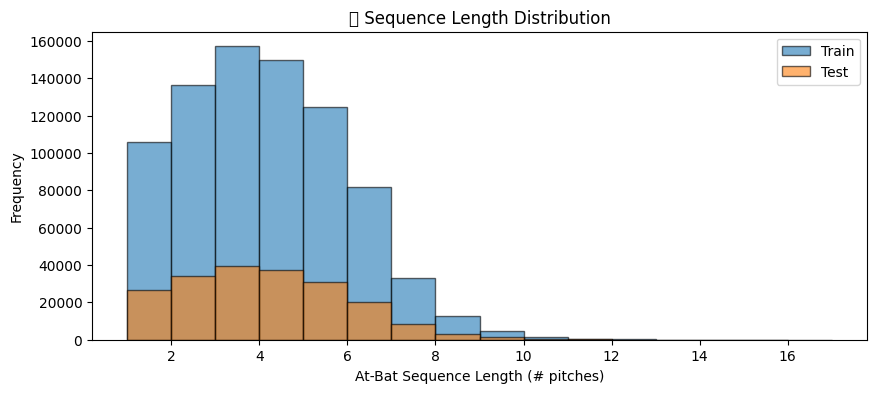

📏 Train sequence lengths: Min=1, Max=16, Mean=3.67
📏 Test sequence lengths: Min=1, Max=17, Mean=3.67

🔢 **Categorical Feature Distributions (Train Set - X)**

Feature Index 0: 5 unique values
   0.0: 1416555
   1.0: 872227
   2.0: 465541
   3.0: 211698
   4.0: 7

Feature Index 1: 4 unique values
   0.0: 1231019
   1.0: 916823
   2.0: 818185
   3.0: 1

Feature Index 2: 3 unique values
   0.0: 1026582
   1.0: 985328
   2.0: 954118

Feature Index 3: 2 unique values
   0.0: 2065800
   1.0: 900228

Feature Index 4: 2 unique values
   0.0: 2435373
   1.0: 530655

Feature Index 5: 2 unique values
   0.0: 2707071
   1.0: 258957

Feature Index 6: 19 unique values
   0.0: 377836
   1.0: 362929
   2.0: 360665
   3.0: 351013
   4.0: 341912
   5.0: 320283
   6.0: 298982
   7.0: 289763
   8.0: 226423
   9.0: 22454
   ... (truncated)

Feature Index 7: 2 unique values
   0.0: 1511649
   1.0: 1454379

Feature Index 10: 2 unique values
   1.0: 1748696
   0.0: 1217332

Feature Index 11: 2 unique values
 

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import collections

def analyze_dataset(X_train, X_test, Y_train, Y_test, categorical_indices, numerical_indices):
    """
    Analyze training and test dataset properties, including Y.
    
    - X_train, X_test: List of at-bat sequences, each a list of pitch feature vectors.
    - Y_train, Y_test: List of at-bat sequences, each a dict with keys {'type', 'cont', 'result_desc', 'result_event'}.
    - categorical_indices: List of indices for categorical features in X.
    - numerical_indices: List of indices for numerical features in X.
    """
    print("\n🚀 **DATASET ANALYSIS** 🚀\n")

    # Dataset sizes
    print(f"🔹 Training set: {len(X_train)} at-bats ({sum(len(x) for x in X_train)} pitches)")
    print(f"🔹 Test set: {len(X_test)} at-bats ({sum(len(x) for x in X_test)} pitches)")
    print(f"🔹 Y_train size: {len(Y_train)} at-bats")
    print(f"🔹 Y_test size: {len(Y_test)} at-bats")

    # **Check if X and Y have the same at-bat counts**
    assert len(X_train) == len(Y_train), "❌ Mismatch between X_train and Y_train sizes!"
    assert len(X_test) == len(Y_test), "❌ Mismatch between X_test and Y_test sizes!"
    print("✅ X and Y sizes are consistent.")

    # **Sequence Lengths (Distribution)**
    train_lengths = [len(seq) for seq in X_train]
    test_lengths = [len(seq) for seq in X_test]
    
    plt.figure(figsize=(10, 4))
    plt.hist(train_lengths, bins=range(min(train_lengths), max(train_lengths) + 1), alpha=0.6, label="Train", edgecolor='black')
    plt.hist(test_lengths, bins=range(min(test_lengths), max(test_lengths) + 1), alpha=0.6, label="Test", edgecolor='black')
    plt.xlabel("At-Bat Sequence Length (# pitches)")
    plt.ylabel("Frequency")
    plt.title("📊 Sequence Length Distribution")
    plt.legend()
    plt.show()

    print(f"📏 Train sequence lengths: Min={min(train_lengths)}, Max={max(train_lengths)}, Mean={np.mean(train_lengths):.2f}")
    print(f"📏 Test sequence lengths: Min={min(test_lengths)}, Max={max(test_lengths)}, Mean={np.mean(test_lengths):.2f}\n")

    # **Categorical Feature Analysis in X**
    cat_counts = {idx: collections.Counter() for idx in categorical_indices}
    
    for x_seq in X_train:
        for pitch in x_seq:
            for idx in categorical_indices:
                cat_counts[idx][pitch[idx]] += 1  # Count occurrences of each value

    print("🔢 **Categorical Feature Distributions (Train Set - X)**")
    for idx, counter in cat_counts.items():
        print(f"\nFeature Index {idx}: {len(counter)} unique values")
        for key, count in counter.most_common(10):  # Show top 10 most frequent
            print(f"   {key}: {count}")
        if len(counter) > 10:
            print("   ... (truncated)")

    # **Numerical Feature Statistics in X**
    num_values = {idx: [] for idx in numerical_indices}

    for x_seq in X_train:
        for pitch in x_seq:
            for idx in numerical_indices:
                num_values[idx].append(pitch[idx])

    print("\n📉 **Numerical Feature Statistics (Train Set - X)**")
    for idx, values in num_values.items():
        values = np.array(values)
        print(f"\nFeature Index {idx}: Min={values.min():.2f}, Max={values.max():.2f}, Mean={values.mean():.2f}, Std={values.std():.2f}")

    # --------------------------
    # **Analyze Y Sequences**
    # --------------------------

    # **Check Distribution of Pitch Types in Y**
    type_counts = collections.Counter()
    desc_counts = collections.Counter()
    event_counts = collections.Counter()
    cont_values = {i: [] for i in range(5)}  # Stores numerical `cont` values

    for y_seq in Y_train:
        for y_t in y_seq:
            type_counts[y_t['type']] += 1
            desc_counts[y_t['result_desc']] += 1
            event_counts[y_t['result_event']] += 1
            for i, val in enumerate(y_t['cont']):
                cont_values[i].append(val)

    # **Pitch Type Distribution**
    print("\n🎯 **Pitch Type Distribution (Train Set - Y)**")
    for pitch_type, count in type_counts.most_common(10):
        print(f"   {pitch_type}: {count}")
    if len(type_counts) > 10:
        print("   ... (truncated)")

    # **Pitch Result Description Distribution**
    print("\n📝 **Pitch Result Description (Train Set - Y)**")
    for desc, count in desc_counts.most_common(10):
        print(f"   {desc}: {count}")
    if len(desc_counts) > 10:
        print("   ... (truncated)")

    # **Pitch Result Event Distribution**
    print("\n⚾ **Pitch Result Event (Train Set - Y)**")
    for event, count in event_counts.most_common(10):
        print(f"   {event}: {count}")
    if len(event_counts) > 10:
        print("   ... (truncated)")

    # **Numerical Feature Statistics in Y (cont values)**
    print("\n📊 **Numerical Features in Y_cont (Train Set)**")
    for idx, values in cont_values.items():
        values = np.array(values)
        print(f"\nFeature {idx}: Min={values.min():.2f}, Max={values.max():.2f}, Mean={values.mean():.2f}, Std={values.std():.2f}")

    print("\n✅ **Full Dataset Analysis Complete!** ✅\n")


analyze_dataset(X_train, X_test, Y_train, Y_test, cat_indices, num_indices)


In [ ]:
print(len(df['pitcher'].unique()))
print(len(df['batter'].unique()))
print(len(df['pitch_type'].unique()))

In [124]:
print(f"Total At-Bat Sequences: {len(X_sequences)}")

# Check the length of a few sequences
print("Example sequence lengths:")
for i in range(5):  # Check first 5 at-bats
    print(f"At-bat {i}: {len(X_sequences[i])} pitches")


print(f"Total At-Bat Sequences: {len(Y_sequences)}")

# Check the length of a few sequences
print("Example sequence lengths:")
for i in range(5):  # Check first 5 at-bats
    print(f"At-bat {i}: {len(Y_sequences[i])} pitches")

Total At-Bat Sequences: 1010397
Example sequence lengths:
At-bat 0: 2 pitches
At-bat 1: 5 pitches
At-bat 2: 4 pitches
At-bat 3: 2 pitches
At-bat 4: 1 pitches
Total At-Bat Sequences: 1010397
Example sequence lengths:
At-bat 0: 2 pitches
At-bat 1: 5 pitches
At-bat 2: 4 pitches
At-bat 3: 2 pitches
At-bat 4: 1 pitches


In [129]:
NUM_AT_BATS = 3  #Number of at-bats to check
for ab_idx in range(NUM_AT_BATS):
    print(f"\nAt-Bat {ab_idx+1} (Total Pitches: {len(X_sequences[ab_idx])})")
    for i, pitch in enumerate(X_sequences[ab_idx]):
        print(f"  Pitch {i+1}: {pitch}")
        print(f"  Feature Count: {len(pitch)}\n")


NUM_AT_BATS = 3  #Number of at-bats to check
for ab_idx in range(NUM_AT_BATS):
    print(f"\nAt-Bat {ab_idx+1} (Total Pitches: {len(Y_sequences[ab_idx])})")
    for i, pitch in enumerate(Y_sequences[ab_idx]):
        print(f"  Pitch {i+1}: {pitch}")
        print(f"  Feature Count: {len(pitch)}\n")


At-Bat 1 (Total Pitches: 2)
  Pitch 1: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(527054), np.int64(543829), 1, 'NONE', np.float64(90.3), np.float64(2274.0), np.float64(6.3), np.float64(0.04), np.float64(2.28), 'NONE', 'NONE']
  Feature Count: 23

  Pitch 2: [np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(527054), np.int64(543829), 0, 'FF', np.float64(91.9), np.float64(2415.0), np.float64(6.3), np.float64(0.31), np.float64(1.72), 'IN_PROGRESS', 'called_strike']
  Feature Count: 23


At-Bat 2 (Total Pitches: 5)
  Pitch 1: [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(527054), np.int64(592885), 1, 'NONE', np.float64(90.3), np.float6

In [223]:
def check_feature_outliers(X_sequences):
    """
    Checks how many values in X_sequences fall outside of the suggested valid ranges
    for release speed, release spin rate, plate_x, and plate_z.
    """

    # Define valid ranges for each feature
    VALID_RANGES = {
        "release_speed": (50, 110),      # MPH
        "release_spin_rate": (500, 3700),  # RPM
        "plate_x": (-3, 3),              # Feet
        "plate_z": (-1, 4)                 # Feet
    }

    # Indices of the features in the X_sequences
    FEATURE_INDICES = {
        "release_speed": 16,
        "release_spin_rate": 17,
        "plate_x": 19,
        "plate_z": 20
    }

    # Initialize counters for out-of-range values
    outlier_counts = {feature: 0 for feature in VALID_RANGES.keys()}
    total_counts = {feature: 0 for feature in VALID_RANGES.keys()}

    # Iterate over each pitch in each at-bat sequence
    for at_bat in X_sequences:
        for pitch in at_bat:
            for feature, (lower, upper) in VALID_RANGES.items():
                idx = FEATURE_INDICES[feature]
                value = pitch[idx]

                if isinstance(value, (int, float)):  # Ensure it's numeric
                    total_counts[feature] += 1
                    if value < lower or value > upper:
                        outlier_counts[feature] += 1

    # Display results
    print("\nOutlier Analysis for Selected Numeric Features:")
    for feature in VALID_RANGES.keys():
        total = total_counts[feature]
        outliers = outlier_counts[feature]
        print(f"  {feature}: {outliers}/{total} ({(outliers / total) * 100:.2f}% outliers)")

# Run the check on X_sequences
check_feature_outliers(X_sequences)



Outlier Analysis for Selected Numeric Features:
  release_speed: 0/3747180 (0.00% outliers)
  release_spin_rate: 0/3747180 (0.00% outliers)
  plate_x: 0/3747180 (0.00% outliers)
  plate_z: 0/3747180 (0.00% outliers)


In [ ]:
for i, at_bat in enumerate(X_sequences[:3]):  # Check first 3 at-bats
    print(f"\nAt-Bat {i+1} (Total Pitches: {len(at_bat)})")
    for j, pitch in enumerate(at_bat):
        extracted_numeric = [pitch[idx] for idx in NUMERIC_INDICES]
        print(f"  Pitch {j+1} Numeric Features: {extracted_numeric}")

In [235]:
# Set a limit for the number of values to print per column
max_display = 15  # Change this if you want more/less displayed

print("\n=== Categorical Value Mappings (Limited View) ===")
for col_idx in cat_indices:
    le = label_encoders_X[col_idx]
    mapping_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    
    # Print total unique values in this categorical column
    print(f"\nColumn {col_idx} - Total Unique Categories: {len(mapping_dict)}")

    # Print only a limited number of mappings
    for i, (original, encoded) in enumerate(mapping_dict.items()):
        if i >= max_display:
            print("   ... (truncated)")
            break
        print(f"   {original} -> {encoded}")
    
    # Optional: Store full mapping for later debugging (don't print it)
    full_mappings = mapping_dict

print("\n===================================")



=== Categorical Value Mappings (Limited View) ===

Column 0 - Total Unique Categories: 5
   0 -> 0
   1 -> 1
   2 -> 2
   3 -> 3
   4 -> 4

Column 1 - Total Unique Categories: 4
   0 -> 0
   1 -> 1
   2 -> 2
   3 -> 3

Column 2 - Total Unique Categories: 3
   0 -> 0
   1 -> 1
   2 -> 2

Column 3 - Total Unique Categories: 2
   0 -> 0
   1 -> 1

Column 4 - Total Unique Categories: 2
   0 -> 0
   1 -> 1

Column 5 - Total Unique Categories: 2
   0 -> 0
   1 -> 1

Column 6 - Total Unique Categories: 19
   0 -> 0
   1 -> 1
   2 -> 2
   3 -> 3
   4 -> 4
   5 -> 5
   6 -> 6
   7 -> 7
   8 -> 8
   9 -> 9
   10 -> 10
   11 -> 11
   12 -> 12
   13 -> 13
   14 -> 14
   ... (truncated)

Column 7 - Total Unique Categories: 2
   0 -> 0
   1 -> 1

Column 10 - Total Unique Categories: 2
   0 -> 0
   1 -> 1

Column 11 - Total Unique Categories: 2
   0 -> 0
   1 -> 1

Column 12 - Total Unique Categories: 878
   424144 -> 0
   425794 -> 1
   425844 -> 2
   434378 -> 3
   445213 -> 4
   445276 -> 5
   44

In [296]:
unique_cats = {i: set() for i in cat_indices}

    # Collect unique values from X_sequences
for at_bat in X_sequences:
    for pitch in at_bat:
        for i in cat_indices:
            unique_cats[i].add(pitch[i])

    # Print results with a limited display
print("\n=== Unique Categorical Values Before Encoding ===")
for col_idx, values in unique_cats.items():
    print(f"\nColumn {col_idx} - Total Unique Categories: {len(values)}")
    for j, val in enumerate(sorted(values)):  # Sort for better readability
        if j >= max_display:
            print("   ... (truncated)")
            break
        print(f"   {val}")

print("\n===================================")
    
#print(unique_cats)  # Return the dictionary if you want to inspect further


=== Unique Categorical Values Before Encoding ===

Column 0 - Total Unique Categories: 5
   0
   1
   2
   3
   4

Column 1 - Total Unique Categories: 4
   0
   1
   2
   3

Column 2 - Total Unique Categories: 3
   0
   1
   2

Column 3 - Total Unique Categories: 2
   0
   1

Column 4 - Total Unique Categories: 2
   0
   1

Column 5 - Total Unique Categories: 2
   0
   1

Column 6 - Total Unique Categories: 19
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
   11
   12
   13
   14
   ... (truncated)

Column 7 - Total Unique Categories: 2
   0
   1

Column 10 - Total Unique Categories: 2
   0
   1

Column 11 - Total Unique Categories: 2
   0
   1

Column 12 - Total Unique Categories: 878
   424144
   425794
   425844
   434378
   445213
   445276
   445926
   446321
   446372
   448179
   448281
   450203
   453178
   453265
   453268
   ... (truncated)

Column 13 - Total Unique Categories: 3095
   112526
   116338
   120074
   121347
   133380
   134181
   136860
   150029
   

In [133]:
import numpy as np

def verify_processed_data(X_sequences, processed_X, Y_sequences, processed_Y, num_indices, cat_indices):
    """
    Verifies that processed X and Y sequences retain their original shape, 
    categorical encoding is correct, and numerical scaling is valid.

    Parameters:
        X_sequences (list): Original nested list of pitch sequences.
        processed_X (list): Transformed X sequences with encoded and scaled features.
        Y_sequences (list): Original nested list of dictionaries for Y.
        processed_Y (list): Processed Y sequences, a list of at-bat sequences.
        num_indices (list): Indices of numerical features in X.
        cat_indices (list): Indices of categorical features in X.
    """

    print("=== SHAPE VERIFICATION ===")
    
    # Check at-bat counts
    assert len(X_sequences) == len(processed_X), "Mismatch in at-bat count for X"
    assert len(Y_sequences) == len(processed_Y), "Mismatch in at-bat count for Y"

    # Check pitch sequence lengths
    for i, (orig_x, proc_x, orig_y, proc_y) in enumerate(zip(X_sequences, processed_X, Y_sequences, processed_Y)):
        assert len(orig_x) == len(proc_x), f"Mismatch in pitch count in X at-bat {i}"
        assert len(orig_y) == len(proc_y), f"Mismatch in pitch count in Y at-bat {i}"
        assert len(orig_x[0]) == len(proc_x[0]), f"Mismatch in feature count in X at-bat {i}"

    print("✅ X and Y shape verified.")

    print("\n=== CATEGORICAL ENCODING VERIFICATION ===")
    
    # Store original and processed categorical values
    original_cats = {i: set() for i in cat_indices}
    encoded_cats = {i: set() for i in cat_indices}

    # Collect original categorical values
    for at_bat in X_sequences:
        for pitch in at_bat:
            for i in cat_indices:
                original_cats[i].add(pitch[i])

    # Collect encoded categorical values
    for at_bat in processed_X:
        for pitch in at_bat:
            for i in cat_indices:
                encoded_cats[i].add(pitch[i])

    # Compare original vs encoded
    for i in cat_indices:
        assert len(original_cats[i]) == len(encoded_cats[i]), f"Mismatch in categorical encoding for feature index {i}"
    
    print("✅ Categorical encoding verified.")

    print("\n=== NUMERICAL SCALING VERIFICATION ===")

    # Extract numerical features from processed_X
    processed_num_features = np.array([
        [pitch[i] for i in num_indices] for at_bat in processed_X for pitch in at_bat
    ], dtype=np.float64)

    mean_values = np.mean(processed_num_features, axis=0)
    std_values = np.std(processed_num_features, axis=0)

    print(f"Mean values (should be ~0): {mean_values}")
    print(f"Standard deviations (should be ~1): {std_values}")

    assert np.allclose(mean_values, 0, atol=0.1), "Mean is not close to 0, scaling issue"
    assert np.allclose(std_values, 1, atol=0.1), "Standard deviation is not close to 1, scaling issue"
    print("✅ Numerical scaling verified.")

    print("\n=== Y_cont SCALING VERIFICATION ===")

    # Extract 'cont' values properly
    Y_cont_array = np.array([y_t['cont'] for seq in processed_Y for y_t in seq], dtype=np.float64)

    mean_Y_cont = np.mean(Y_cont_array, axis=0)
    std_Y_cont = np.std(Y_cont_array, axis=0)

    print(f"Y_cont mean values (should be ~0): {mean_Y_cont}")
    print(f"Y_cont standard deviations (should be ~1): {std_Y_cont}")

    assert np.allclose(mean_Y_cont, 0, atol=0.1), "Y_cont mean is not close to 0"
    assert np.allclose(std_Y_cont, 1, atol=0.1), "Y_cont standard deviation is not close to 1"
    print("✅ Y_cont scaling verified.")


In [131]:
import numpy as np

def verify_processed_dataasd(X_sequences, processed_X, Y_sequences, processed_Y, num_indices, cat_indices):
    """
    Verifies that processed X and Y sequences retain their original shape, 
    categorical encoding is correct, and numerical scaling is valid.

    Parameters:
        X_sequences (list): Original nested list of pitch sequences.
        processed_X (list): Transformed X sequences with encoded and scaled features.
        Y_sequences (list): Original nested list of dictionaries for Y.
        processed_Y (dict): Processed dictionary containing encoded/scaled Y components.
        num_indices (list): Indices of numerical features in X.
        cat_indices (list): Indices of categorical features in X.
    """

    print("=== SHAPE VERIFICATION ===")
    assert len(X_sequences) == len(processed_X), "Mismatch in at-bat count"
    for i, (orig, proc) in enumerate(zip(X_sequences, processed_X)):
        assert len(orig) == len(proc), f"Mismatch in pitch count in at-bat {i}"
        assert len(orig[0]) == len(proc[0]), f"Mismatch in feature count in at-bat {i}"
    print("✅ X shape verified.")

    assert len(Y_sequences) == len(processed_Y['type']), "Mismatch in Y at-bat count"
    for i, (orig, proc_type, proc_cont, proc_desc, proc_event) in enumerate(zip(Y_sequences, processed_Y['type'], processed_Y['cont'], processed_Y['result_desc'], processed_Y['result_event'])):
        assert len(orig) == len(proc_type) == len(proc_cont) == len(proc_desc) == len(proc_event), f"Mismatch in pitch count in Y at-bat {i}"
    print("✅ Y shape verified.")

    print("\n=== CATEGORICAL ENCODING VERIFICATION ===")
    original_cats = set()
    encoded_cats = set()

    for at_bat in X_sequences:
        for pitch in at_bat:
            for i in cat_indices:
                original_cats.add(pitch[i])

    for at_bat in processed_X:
        for pitch in at_bat:
            for i in range(len(pitch)):  # Encoded categorical values should be integers
                if i in cat_indices:
                    encoded_cats.add(pitch[i])

    print(f"Original categorical values: {original_cats}")
    print(f"Encoded categorical values: {encoded_cats}")

    print(len(original_cats) == len(encoded_cats)), "Mismatch in categorical encoding"
    print("✅ Categorical encoding verified.")

    print("\n=== NUMERICAL SCALING VERIFICATION ===")
    processed_num_features = []

    for at_bat in processed_X:
        for pitch in at_bat:
            processed_num_features.append([pitch[i] for i in num_indices])

    processed_num_features = np.array(processed_num_features)

    mean_values = np.mean(processed_num_features, axis=0)
    std_values = np.std(processed_num_features, axis=0)

    print(f"Mean values (should be ~0): {mean_values}")
    print(f"Standard deviations (should be ~1): {std_values}")

    assert np.allclose(mean_values, 0, atol=0.1), "Mean is not close to 0, scaling issue"
    assert np.allclose(std_values, 1, atol=0.1), "Standard deviation is not close to 1, scaling issue"
    print("✅ Numerical scaling verified.")

    print("\n=== Y_cont SCALING VERIFICATION ===")
    Y_cont_array = np.array([cont for seq in processed_Y['cont'] for cont in seq])

    mean_Y_cont = np.mean(Y_cont_array, axis=0)
    std_Y_cont = np.std(Y_cont_array, axis=0)

    print(f"Y_cont mean values (should be ~0): {mean_Y_cont}")
    print(f"Y_cont standard deviations (should be ~1): {std_Y_cont}")

    assert np.allclose(mean_Y_cont, 0, atol=0.1), "Y_cont mean is not close to 0"
    assert np.allclose(std_Y_cont, 1, atol=0.1), "Y_cont standard deviation is not close to 1"
    print("✅ Y_cont scaling verified.")


In [134]:
verify_processed_data(X_sequences, processed_X, Y_sequences, processed_Y, num_indices, cat_indices)

=== SHAPE VERIFICATION ===
✅ X and Y shape verified.

=== CATEGORICAL ENCODING VERIFICATION ===
✅ Categorical encoding verified.

=== NUMERICAL SCALING VERIFICATION ===
Mean values (should be ~0): [-1.54397806e-13 -9.14623623e-15 -2.24886452e-13 -6.75048608e-14
 -2.40669974e-12 -1.03868605e-13 -9.51524570e-14]
Standard deviations (should be ~1): [1. 1. 1. 1. 1. 1. 1.]
✅ Numerical scaling verified.

=== Y_cont SCALING VERIFICATION ===
Y_cont mean values (should be ~0): [ 9.21193614e-13  2.32952204e-15 -8.80339385e-13 -1.64679682e-14
 -3.33577595e-13]
Y_cont standard deviations (should be ~1): [1. 1. 1. 1. 1.]
✅ Y_cont scaling verified.


In [12]:
import numpy as np

def format_processed_sequences(processed_X, processed_Y, max_at_bats=2):
    """
    Formats the processed sequences into a readable structure like the original format.
    
    Parameters:
        processed_X (list): Encoded and scaled X sequences.
        processed_Y (dict): Encoded and scaled Y sequences.
        max_at_bats (int, optional): Maximum number of at-bats to display. Default is 2.
    
    Returns:
        str: Formatted string representation of the processed sequences.
    """
    output = []
    
    for at_bat_idx, (x_at_bat, y_type, y_cont, y_desc, y_event) in enumerate(
            zip(processed_X, processed_Y['type'], processed_Y['cont'], processed_Y['result_desc'], processed_Y['result_event'])):
        
        if at_bat_idx >= max_at_bats:
            break  # Stop after reaching max_at_bats

        output.append(f"At-Bat {at_bat_idx + 1} (Total Pitches: {len(x_at_bat)})")
        
        for pitch_idx, (x_pitch, y_type_pitch, y_cont_pitch, y_desc_pitch, y_event_pitch) in enumerate(
                zip(x_at_bat, y_type, y_cont, y_desc, y_event)):
            
            # Convert lists to numpy-friendly format
            formatted_x_pitch = [
                f"np.int64({int(val)})" if isinstance(val, (int, np.integer)) else
                f"np.float64({float(val):.2f})" if isinstance(val, (float, np.floating)) else val
                for val in x_pitch
            ]
            
            # Convert Y_cont (5 numeric features) to formatted np.float64 values
            formatted_y_cont = [f"np.float64({float(val):.2f})" for val in y_cont_pitch]
            
            # Format full Y pitch data
            formatted_y = f"Y -> Type: {y_type_pitch}, Cont: {formatted_y_cont}, Desc: {y_desc_pitch}, Event: {y_event_pitch}"
            
            output.append(f"  Pitch {pitch_idx + 1}: {formatted_x_pitch}")
            output.append(f"  Feature Count: {len(x_pitch)}")
            output.append(f"  {formatted_y}")
            output.append("")  # Blank line for readability
    
    return "\n".join(output)


In [ ]:
formatted_output = format_processed_sequences(processed_X, processed_Y, max_at_bats=4)
print(formatted_output)

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

def extract_features_from_sequences(processed_X, processed_Y, max_at_bats=None):
    """
    Converts processed X and Y sequences into a structured Pandas DataFrame.
    
    Parameters:
        processed_X (list): Encoded and scaled X sequences.
        processed_Y (dict): Encoded and scaled Y sequences.
        max_at_bats (int, optional): Maximum number of at-bats to include in the DataFrame. Default is None (include all).
    
    Returns:
        df (pd.DataFrame): DataFrame containing structured pitch features.
    """
    data = []
    
    for at_bat_idx, (x_at_bat, y_type, y_cont, y_desc, y_event) in enumerate(
            zip(processed_X, processed_Y['type'], processed_Y['cont'], processed_Y['result_desc'], processed_Y['result_event'])):
        
        # Stop if max_at_bats is reached
        if max_at_bats is not None and at_bat_idx >= max_at_bats:
            break
        
        for pitch_idx, (x_pitch, y_type_pitch, y_cont_pitch, y_desc_pitch, y_event_pitch) in enumerate(
                zip(x_at_bat, y_type, y_cont, y_desc, y_event)):
            
            # Flatten X pitch features
            pitch_data = [at_bat_idx + 1, pitch_idx + 1] + x_pitch
            
            # Append Y values separately
            pitch_data += [y_type_pitch] + list(y_cont_pitch) + [y_desc_pitch, y_event_pitch]
            
            # Store data
            data.append(pitch_data)

    # Create column names dynamically
    num_x_features = len(processed_X[0][0])  # Number of features in X
    num_y_cont_features = len(processed_Y['cont'][0][0])  # Number of continuous Y features

    column_names = ['At-Bat', 'Pitch'] + [f'X_{i}' for i in range(num_x_features)] + \
                   ['Y_Type'] + [f'Y_Cont_{i}' for i in range(num_y_cont_features)] + ['Y_Desc', 'Y_Event']

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=column_names)
    
    return df

# Example usage:
df_features = extract_features_from_sequences(processed_X, processed_Y, max_at_bats=None)

# Display first few rows
display(df_features)

# Save to CSV if needed
# df_features.to_csv("pitch_features.csv", index=False)

In [75]:
print(len(df_features['Y_Type'].unique()))

15


In [145]:
def get_unique_values_from_Y(Y_sequences, max_display=10):
    """
    Extracts and prints unique values for 'type', 'desc', and 'event' from Y_sequences before encoding.

    Parameters:
        Y_sequences (list): Original Y sequences containing 'type', 'desc', and 'event'.
        max_display (int, optional): Limits how many unique values are displayed per category.
    
    Returns:
        unique_values (dict): Dictionary of unique values per category.
    """
    unique_values = {
        "Y_Type": set(),
        "Y_Desc": set(),
        "Y_Event": set()
    }

    # Collect unique values
    for at_bat in Y_sequences:
        for pitch in at_bat:
            unique_values["Y_Type"].add(pitch["type"])
            unique_values["Y_Desc"].add(pitch["result"][0])  # First element of 'result' is desc
            unique_values["Y_Event"].add(pitch["result"][1])  # Second element of 'result' is event

    # Print results with a limited display
    print("\n=== Unique Categorical Values in Y Before Encoding ===")
    for category, values in unique_values.items():
        print(f"\n{category} - Total Unique Categories: {len(values)}")
        for j, val in enumerate(sorted(values)):  # Sort for better readability
            if j >= max_display:
                print("   ... (truncated)")
                break
            print(f"   {val}")
    
    print("\n===================================")
    
    return unique_values  # Return dictionary for further use if needed

# Example usage:
unique_Y_values = get_unique_values_from_Y(Y_sequences)



=== Unique Categorical Values in Y Before Encoding ===

Y_Type - Total Unique Categories: 15
   AB
   CH
   CS
   CU
   EP
   FA
   FC
   FF
   FS
   KC
   ... (truncated)

Y_Desc - Total Unique Categories: 13
   ball
   blocked_ball
   bunt_foul_tip
   called_strike
   foul
   foul_bunt
   foul_tip
   hit_by_pitch
   hit_into_play
   intent_ball
   ... (truncated)

Y_Event - Total Unique Categories: 23
   IN_PROGRESS
   catcher_interf
   double
   double_play
   field_error
   field_out
   fielders_choice
   fielders_choice_out
   force_out
   grounded_into_double_play
   ... (truncated)

